In [2]:
# Installing the Libraries
!pip install -Uqq fastbook

In [4]:
import fastbook
fastbook.setup_book()

In [6]:
from fastbook import *
from fastai.vision import *
path = Path(r"D:\Waseem\ML\ML_Batch_3\anaconda\Kidney_stone_detection\Dataset")

In [8]:
# Getting the training images

train_fnames = get_image_files(path/"Train")

In [9]:
# Defining Data Augmenttion and DataBlock
augs = [RandomResizedCropGPU(size=224, min_scale=0.75),Rotate(), Zoom()]

In [16]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                   splitter = RandomSplitter(valid_pct =0.3, seed=23),
                   get_y = parent_label,
                   item_tfms = Resize(512, method = "squish"),
                   batch_tfms=augs,
                    )

In [17]:
dls = dblock.dataloaders(train_fnames)

In [20]:
# Exploring the data

dls.c, len(dls.train_ds), len(dls.valid_ds)

(2, 1018, 435)

In [21]:
dls.vocab

['Kidney_stone', 'Normal']

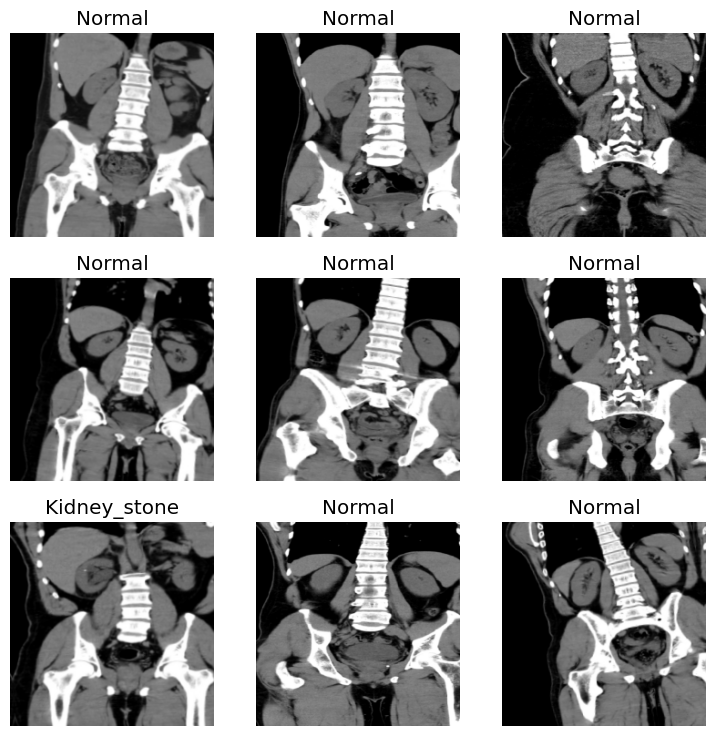

In [24]:
dls.show_batch()


In [26]:
# Defining the Model

model = nn.Sequential(create_body(xresnet50(), pretrained=False),
                      create_head(nf=2048,n_out=2))

In [30]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [33]:
learn.fit(2, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,72.060753,757574.187500,0.583908,07:56
1,45.241077,15057.968750,0.583908,08:09


In [36]:
# Saving the model
learn.save(path/'kidney-50')

Path('D:/Waseem/ML/ML_Batch_3/anaconda/Kidney_stone_detection/Dataset/kidney-50.pth')

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

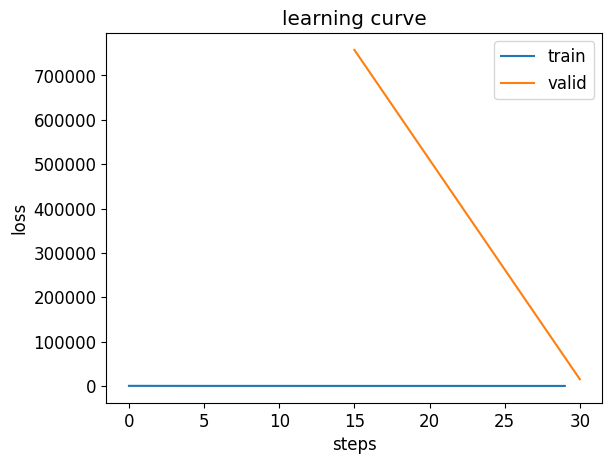

In [37]:
# Ploting the loss
learn.recorder.plot_loss(skip_start=0,with_valid=True)

In [38]:
# Preparing the testing data
all_files = get_image_files(path)

In [40]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImage),CategoryBlock),
                   splitter = GrandparentSplitter(train_name='Train',valid_name='Test'),
                   get_y = parent_label,
                   item_tfms = Resize(512, method = "squish"),
                   batch_tfms=augs,
                    )

In [41]:
dls_test =dblock.dataloaders(all_files)

In [42]:
print("Nuber of Examples in testing:", len(dls_test.valid_ds))

Nuber of Examples in testing: 346


In [43]:
# Load te model for testing

from fastai.vision.models.xresnet import xresnet50
model = nn.Sequential(create_body(xresnet50(), pretrained=False),
                      create_head(nf=2048,n_out=2))

In [46]:
learn1 = Learner(dls_test, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy).load("D:/Waseem/ML/ML_Batch_3/anaconda/Kidney_stone_detection/kidney-50")

C:\Users\XPS\anaconda3\python\envs\test\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

In [47]:
# Evaluate the model performance

interp = ClassificationInterpretation.from_learner(learn1)

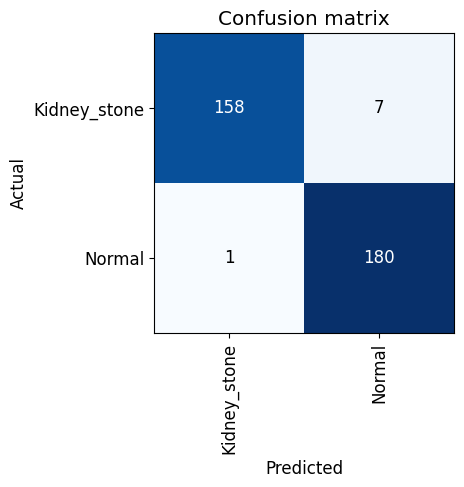

In [49]:
interp.plot_confusion_matrix()

In [50]:
interp.print_classification_report()

              precision    recall  f1-score   support

Kidney_stone       0.99      0.96      0.98       165
      Normal       0.96      0.99      0.98       181

    accuracy                           0.98       346
   macro avg       0.98      0.98      0.98       346
weighted avg       0.98      0.98      0.98       346



In [51]:
# Making Prediction

from PIL import Image
learn1 = Learner(dls_test, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn1.load("D:/Waseem/ML/ML_Batch_3/anaconda/Kidney_stone_detection/kidney-50")

img_path = "D:/Waseem/ML/ML_Batch_3/anaconda/Kidney_stone_detection/Dataset/Test/Kidney_stone/1.3.46.670589.33.1.63706830475347975400001.4676991400730475635.png"
img = PILImage.create(img_path)

pred_class, pred_idx, probs = learn1.predict(img)

print (f"Predicted Class: {pred_class}")
print (f"Confidence Score: {probs}")



C:\Users\XPS\anaconda3\python\envs\test\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

Predicted Class: Kidney_stone
Confidence Score: tensor([9.9997e-01, 3.4073e-05])
